In [3025]:
import numpy as np
import pandas as pd
from num2tex import num2tex

import matplotlib.pyplot as plt

import os

from fpw.test import _plot_figure
from fpw.ProblemGaussian import *



problem = "Median" # "BC" | "KL" | "OU" | "EntBC" | "Median"

## Setup

### Setting params for each problem

In [3026]:
match problem:
    case "BC":
        results_dirs = './outputs/Barycenter/'
        term_name, term_val = 'costs_to_0', 1e-10
    case "KL":
        results_dirs = './outputs/KL_acceleration/'
        term_name, term_val = 'costs', 1e-8
    case "OU":
        results_dirs = './outputs/OU_acceleration/'
        term_name, term_val = 'residuals', 1e-6
    case "EntBC":
        results_dirs = './outputs/EntBarycenter/'
        term_name, term_val = 'costs_to_0', 1e-10
    case "Median":
        #results_dirs = ['./outputs/Median/', 'outputs/Median_d50/']
        results_dirs = "./outputs/MedianNew/"
        term_name, term_val = 'costs_to_0', 1e-10



if isinstance(results_dirs, str):
    results_dirs = [results_dirs]
results_dir = results_dirs[0]

In [3027]:
tab_prefix = os.path.join(results_dir, 'tabs')
os.makedirs(tab_prefix, exist_ok=True)

target_params = ['dim', 'n_sigmas'] if problem in ['BC', 'EntBC', 'Median'] else ['dim', 'sigma_min', 'sigma_max']
method_params = ['history_len', 'l_inf_bound_Gamma', 'relaxation', 'r_threshold']
method_names = ['Picard', 'RGD', 'BWRAM', 'RCG'] if problem != 'OU' else ['Picard', 'BWRAM']

### Utility functions

In [3028]:
def latexify_label(label:str):
    match label:
        case 'dim':
            return r'$d$'
        case 'n_sigmas':
            return r'$n_{\sigma}$'
        case 'sigma_min':
            return r'$\sigma_{min}$'
        case 'sigma_max':
            return r'$\sigma_{max}$'
        case 'history_len':
            return r'$m_{hist}$'
        case 'l_inf_bound_Gamma':
            return r'$\| \Gamma \|_{\inf,\ max}$'
        case 'relaxation':
            return r'$\beta$'
        case 'method':
            return ''
    return label

## Preprocess

### Read the data from files

In [3029]:
res = []
for rdir in results_dirs:
    dir_ = os.path.join(rdir, 'chunks')
    for fname in os.listdir(dir_,):
        if fname.endswith(".pkl"):
            res += pd.read_pickle(os.path.join(dir_, fname))

    df = pd.DataFrame.from_records(res)

In case of legacy data

In [3030]:
df = df.rename(columns={'rs_cov': 'rs'})
if problem in ['BC', 'EntBC', 'Median']:
    df = df.query("dim > 2 and n_sigmas > 2")

### Compute additional columns

If some of the parameters were not varied during the run, drop them

In [3031]:
method_params = [p_ for p_ in method_params if p_ in df.columns and df[p_].nunique() > 1]
target_params = [p_ for p_ in target_params if p_ in df.columns and df[p_].nunique() > 1]

In [3032]:
df['N_steps_done'] =  np.array([ 
    np.where(np.array(c) <= term_val)[0][0] if np.any(np.array(c) <= term_val) else np.inf 
    for c in df[term_name]], )

df['T'] = np.array([(sum(t_[:int(N_)]) if N_ < np.inf else sum(t_)) for t_, N_ in zip(df['dts'], df['N_steps_done'])])
df.loc[df['method'] == 'Picard', 'T'] = np.abs(df.loc[df['method'] == 'Picard', 'T'])

In [3033]:
df.columns

Index(['costs', 'residuals', 'dts', 'covs', 'cov_final', 'dim', 'n_sigmas',
       'rs', 'eps', 'scaling', 'problem', 'vt_kind', 'N_steps_max', 'r_min',
       'cost_min', 'dBW', 'costs_to_0', 'method', 'history_len',
       'l_inf_bound_Gamma', 'relaxation', 'N_steps_done', 'T'],
      dtype='object')

In [3034]:
df_runs_done = \
    df[target_params + ['rs']]\
    .groupby(target_params)\
    .nunique()\
    .pivot_table(index=target_params[0], columns=target_params[1])

n_max_runs = int(df_runs_done.dropna().to_numpy().min())
df_runs_done

rs                  
n_sigmas    3     5     10    20
dim                             
3         11.0  12.0  12.0  12.0
5         12.0  12.0  12.0  12.0
10        12.0  12.0  12.0  12.0
20        12.0  12.0  12.0  12.0
50        12.0  12.0  12.0  12.0

### Compute acceleration compared to Picard

In [3035]:
grouped_by_target = df.groupby(target_params + ['rs'])

accs = []

for name, group in grouped_by_target:
    acc = group.loc[group['method'] == 'Picard', 'N_steps_done'].to_numpy() / group['N_steps_done']
    accs.append(acc)
    
acceleration = pd.concat(accs)
df['acceleration'] = acceleration

In [3036]:
# drop extra random seeds so we average over the same amount
idx_to_leave = []
for name, group in df.groupby(target_params):
    rs_to_leave = group['rs'].unique()[:n_max_runs]
    idx_to_leave.append(group['rs'].isin(rs_to_leave))

idx_to_leave = pd.concat(idx_to_leave)
df = df.loc[idx_to_leave, :]

In [3037]:
df_runs_done = \
    df[target_params + ['rs']]\
    .groupby(target_params)\
    .nunique()\
    .pivot_table(index=target_params[0], columns=target_params[1])
df_runs_done

rs                  
n_sigmas    3     5     10    20
dim                             
3         11.0  11.0  11.0  11.0
5         11.0  11.0  11.0  11.0
10        11.0  11.0  11.0  11.0
20        11.0  11.0  11.0  11.0
50        11.0  11.0  11.0  11.0

## Compute max mean acceleration w.r.t. target params

In [3038]:
df_acc = df.loc[df['method'] == 'BWRAM', target_params + method_params + ['rs', 'acceleration']]

For each set of target params and method params, average the acceleration over random initializations of target (encoded by different `'rs'`)

In [3039]:
col_to_avg = [c for c in df_acc.columns if c not in ('rs', 'acceleration')]
df_mean = df_acc.groupby(col_to_avg, as_index=False, dropna=False).mean().drop(columns=['rs', ])

### For each target, dump more detailed info into `.html` tables

In [3040]:
import os
tab_prefix = os.path.join(results_dir, 'tabs')
os.makedirs(tab_prefix, exist_ok=True)

group_by_target = df_mean.groupby(target_params)

for group_data, group in group_by_target:
    kwal_probl = dict(zip(target_params, group_data))
    group\
        .sort_values('acceleration', ascending=False)\
        .to_html(os.path.join(tab_prefix, f"{kwal_probl}.html"))
    

### Compute maximal mean acceleration over all method params for each target params

In [3041]:
df_max_mean_acc = df_mean.groupby(target_params).max()

In [3042]:
tab_final = pd.pivot_table(df_max_mean_acc, 
                           values='acceleration', 
                           index=target_params[0], 
                           columns=target_params[1], 
                           dropna=False)

In [3043]:
tab_renamed = tab_final\
    .rename_axis(latexify_label(tab_final.index.name), axis='index')\
    .rename_axis(latexify_label(tab_final.columns.name), axis='columns')\
    .rename(columns=lambda _x: f"${_x:.1f}$")

In [3044]:
tab_renamed.style.format('${:.2f}$').to_latex(
    os.path.join(tab_prefix, problem + "_max_mean_acc.tex"), hrules=True, clines="skip-last;data"
)

In [3045]:
tab_renamed.style.format('${:.2f}$')

$n_{\sigma}$,$3.0$,$5.0$,$10.0$,$20.0$
$d$,,,,
3,$2.00$,$2.00$,$1.86$,$1.90$
5,$3.94$,$4.23$,$4.49$,$4.45$
10,$10.07$,$9.19$,$9.70$,$8.97$
20,$20.27$,$17.85$,$17.86$,$17.13$
50,$25.57$,$23.40$,$21.11$,$22.05$


## Compute mean number of steps for each method

### Average over random initialization

In [3046]:
df_nsteps = df.loc[:, target_params + method_params + ['method', 'rs', 'N_steps_done']]

col_to_avg = [c for c in df_nsteps.columns if c not in ('rs', 'N_steps_done')]
df_mean_steps = df_nsteps.groupby(by=col_to_avg, as_index=False, dropna=False).mean()

### Choose best for each target and method (among different values of hyperparameters)

In [3047]:
tab_n_steps = pd.pivot_table(df_mean_steps, 
                                index=target_params, 
                                columns='method', 
                                values='N_steps_done', aggfunc='min')
tab_n_steps = tab_n_steps[method_names]
# tab_n_steps = tab_n_steps.rename(columns=lambda _x: f"{int(_x):2d}",)
tab_n_steps = tab_n_steps.rename(index=lambda _x: f"{_x:.1f}" if isinstance(_x, float) else _x, level=1)

In [3048]:
ts = tab_n_steps\
    .rename_axis(index=[latexify_label(l_) for l_ in tab_n_steps.index.names], 
                columns=[latexify_label(l_) for l_ in tab_n_steps.columns.names])\
    .style.format('{:.1f}' , escape='latex')\
    .highlight_min(axis=1, props='font-weight:bold')

df_mean_steps.to_pickle(os.path.join('./', problem + '_n_steps_by_method.pkl'))
ts.to_html(os.path.join(tab_prefix, problem + '_n_steps_by_method.html'))
ts.to_latex(os.path.join(tab_prefix, problem + '_n_steps_by_method.tex'),
            convert_css=True, hrules=True, clines="skip-last;data")
ts.to_latex(os.path.join('./', problem + '_n_steps_by_method.tex'),
            convert_css=True, hrules=True, clines="skip-last;data")

In [3049]:
ts

## Plotting

### $\operatorname{OU}$

In [3050]:
if problem == 'OU':
    df_to_plot = df\
        .query("(dim == 4 and sigma_max == 20.0 and rs == 6) and ((method != @m) or (method == @m and history_len <= 9.0))")
    rp = df_to_plot.to_dict('records')
    
    probl = OUEvolution(**rp[0])
    
    fig = _plot_figure(probl, rp, './', key='residuals', n_max_plot=5)
    
    %matplotlib inline
    
    ax : plt.axes = fig.get_axes()[0]
    # ax.set_ylabel(r'$r(\Sigma_k| \Sigma_*)$')
    ax.set_ylim(bottom=(term_val-0.3*term_val), top=rp[0]['residuals'][0]*1.1)
    fig.tight_layout()
    fig.savefig("OU_conv_final.pdf")

### $\operatorname{KL}$

In [3051]:
m = 'BWRAM'
if problem == 'KL':
    df_to_plot = df\
        .query("(dim == 4 and sigma_max == 20.0 and rs == 6) and ((method != @m) or (method == @m and relaxation == 0.9 and l_inf_bound_Gamma == 1.5 and history_len <= 7.0))")
    rp = df_to_plot.to_dict('records')
    
    probl = WGKL(**rp[0])
    
    fig = _plot_figure(probl, rp, './', key='costs', n_max_plot=10)
    
    %matplotlib inline
    
    ax : plt.axes = fig.get_axes()[0]
    ax.set_ylabel(r'$\operatorname{KL}(\Sigma_k| \Sigma_*)$')
    ax.set_ylim(bottom=(term_val-0.3*term_val), top=rp[0]['costs'][0]*1.1)
    fig.tight_layout()
    fig.savefig("KL_conv_final.pdf")

### Barycenters

In [3052]:
if problem == 'BC':
    df_to_plot = df\
        .query("(dim == 50 and n_sigmas == 3 and rs == 4) and ((method != @m) or (method == @m and relaxation == 1.2 and  l_inf_bound_Gamma == 1.5 and history_len <= 11.0))")
        #.query("(dim == 20 and n_sigmas == 3 and rs == 2) and ((method != @m) or (method == @m and relaxation == 1.2 and  l_inf_bound_Gamma == 1.5 and history_len <= 11.0))")
    rp = df_to_plot.to_dict('records')
    
    probl = Barycenter(**rp[0])
    
    fig = _plot_figure(probl, rp, './', key='costs_to_0', n_max_plot=10)
    
    
    ax : plt.axes = fig.get_axes()[0]
    ax.set_ylabel(r'$B(\Sigma_k) - B(\Sigma_*)$')
    ax.set_xlim(left=0, right=rp[0]['N_steps_done'])
    ax.set_ylim(bottom=(term_val-0.3*term_val), top=rp[0]['costs_to_0'][0]*1.1)
    fig.tight_layout()
    fig.savefig("BC_conv_final.pdf")

### Entropic Barycenter

In [3053]:
m = 'BWRAM'
if problem == 'EntBC':
    key_to_plot = 'costs_to_0'
    df_to_plot = df\
        .query("(dim == 50 and n_sigmas == 3 and rs == 4) and ((method != @m) or (method == @m and relaxation == 1.2 and l_inf_bound_Gamma == 1.5))")
    rp = df_to_plot.to_dict('records')
    
    probl = EntropicBarycenter(**rp[0])
    
    fig = _plot_figure(probl, rp, './', key=key_to_plot, n_max_plot=10)
    
    
    ax : plt.axes = fig.get_axes()[0]
    ax.set_ylabel(r'$B_\gamma(\Sigma_k) - B_\gamma(\Sigma_*)$')
    ax.set_xlim(left=0, right=rp[0]['N_steps_done'])
    ax.set_ylim(bottom=max(1e-11, (0.9*rp[0][key_to_plot][-1])), top=rp[0][key_to_plot][0]*1.1)
    fig.tight_layout()
    fig.savefig("EntBC_conv_final.pdf")

### Medians

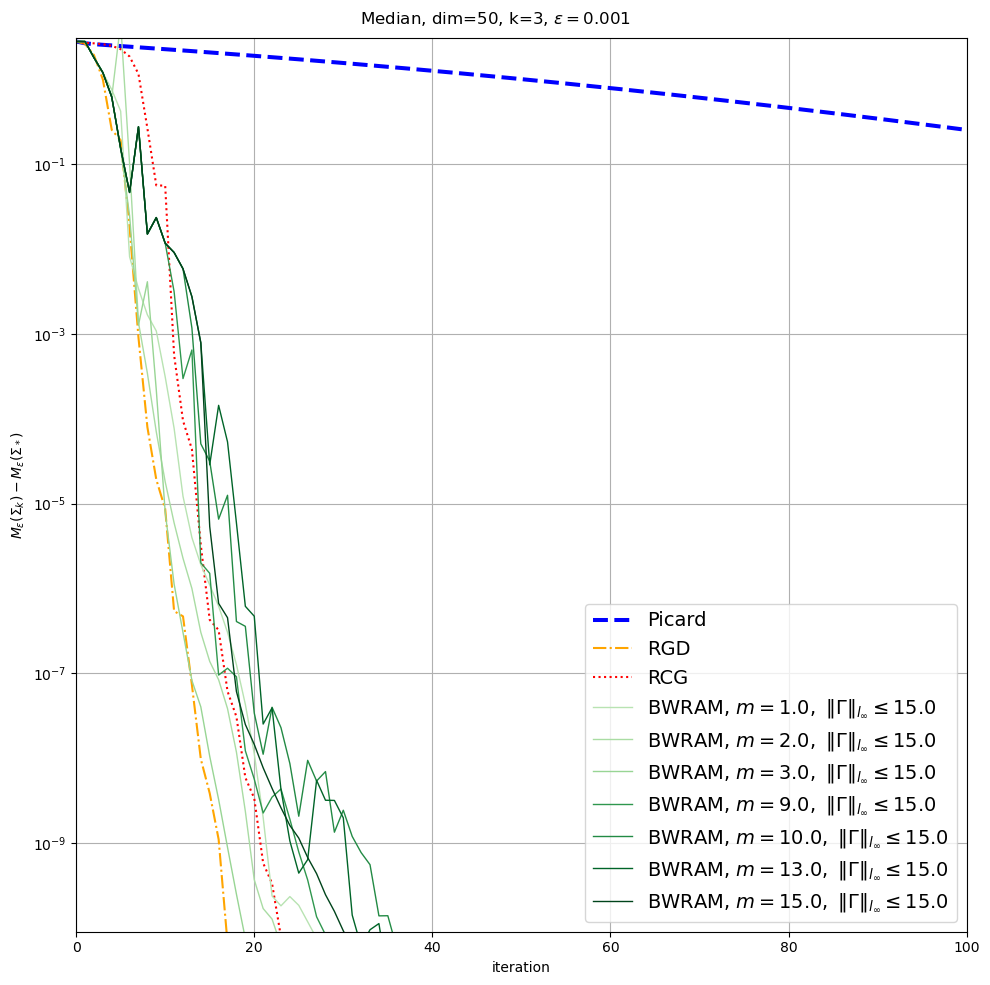

In [3054]:
m = 'BWRAM'
if problem == 'Median':
    key_to_plot = 'costs_to_0'
    df_to_plot = df\
        .query("(dim == 50 and n_sigmas == 3 and rs == 2) and ((method != @m) or (method == @m and relaxation == 10. and l_inf_bound_Gamma == 15.0))")
    rp = df_to_plot.to_dict('records')
    
    probl = Median(**rp[0])
    
    fig = _plot_figure(probl, rp, './', key=key_to_plot, n_max_plot=10)
    
    
    ax : plt.axes = fig.get_axes()[0]
    ax.set_ylabel(r'$M_\varepsilon(\Sigma_k) - M_\varepsilon(\Sigma_*)$')
    # ax.set_xlim(left=0, right=rp[0]['N_steps_done'])
    ax.set_xlim(left=0, right=100)
    ax.set_ylim(bottom=max(rp[0][key_to_plot][-1], term_val)*0.9, top=rp[0][key_to_plot][0]*1.1)
    fig.tight_layout()
    fig.savefig("Median_conv_final.pdf")

### Select values for plotting


In [3055]:
m = 'BWRAM'
df_filtered = df.query("method == @m and dim == 50 and n_sigmas == 3")[['rs'] + target_params+ ['method'] + method_params + ['N_steps_done', 'acceleration']]

In [3056]:
df_filtered.sort_values('acceleration', ascending=False).head(40)

,rs,dim,n_sigmas,method,history_len,l_inf_bound_Gamma,relaxation,N_steps_done,acceleration
25973,2,50,3,BWRAM,3.0,15.0,10.0,19.0,34.421053
24626,3,50,3,BWRAM,7.0,1.5,10.0,22.0,33.272727
25970,2,50,3,BWRAM,3.0,1.5,10.0,20.0,32.700000
24638,3,50,3,BWRAM,8.0,15.0,10.0,23.0,31.826087
25961,2,50,3,BWRAM,2.0,1.5,10.0,21.0,31.142857
14675,11,50,3,BWRAM,5.0,15.0,10.0,26.0,30.884615
6365,8,50,3,BWRAM,2.0,1.5,10.0,26.0,30.461538
6401,8,50,3,BWRAM,6.0,1.5,10.0,26.0,30.461538
2384,5,50,3,BWRAM,4.0,15.0,10.0,22.0,30.000000
2381,5,50,3,BWRAM,4.0,1.5,10.0,22.0,30.000000


## Common table for 3 last experiments

In [3080]:
probls = ["BC", "EntBC", "Median"]
dfs = [pd.read_pickle(_p + '_n_steps_by_method.pkl') for _p in probls]
for _p, _df in zip(probls, dfs):
    _df['problem'] = _p
df_all = pd.concat(dfs)
tab_n_steps = pd.pivot_table(df_all, 
                                index=target_params, 
                                columns=['problem', 'method'], 
                                values='N_steps_done', aggfunc='min')

tab_n_steps = tab_n_steps.rename(index=lambda _x: f"{_x:.1f}" if isinstance(_x, float) else _x, level=1)

In [3086]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight:bold' if v else '' for v in is_min]

styled_df = tab_n_steps.rename_axis(index=[latexify_label(l_) for l_ in tab_n_steps.index.names], 
                columns=[latexify_label(l_) for l_ in tab_n_steps.columns.names]).style
for group in tab_n_steps.columns.get_level_values(0).unique():
    group_cols = tab_n_steps.columns[tab_n_steps.columns.get_level_values(0) == group]
    styled_df = styled_df.apply(highlight_min, subset=group_cols, axis=1, )
    
ts = styled_df.format('{:.1f}' , escape='latex')
        
    # .highlight_min(axis=1, props='font-weight:bold')



ts.to_latex(os.path.join('./', 'Averaging_n_steps_by_method.tex'),
            convert_css=True, hrules=True, clines="skip-last;data")
ts